# Module: calibration

This module contains functions for calibration of 4DSTEM data, including calibrating pixel sizes, calibrating the rotational offset between the real and diffraction planes, correcting diffraction shifts, and correcting elliptical distortions.

### Beamstop calibration

Calibration looks substantively different for data in which a beam stop was used.  The central difference is the absence of an unscattered beam in beamstop data, therefore requiring slighly more involved methods to determine the diffraction shifts.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import binary_closing, binary_opening, binary_dilation, binary_erosion

import py4DSTEM

In [15]:
# Get data
fp = "/home/ben/Data/20190302_calibrationData_Al_standards/BeamStop__from_20190302_LiFePO4_50percentLithiated/Al_Probe_25x25_ss10nm_0p01s_spot8_alpha=0p48_bin2_cl-300mm_300kV.dm4"
dc = py4DSTEM.file.io.read(fp)
dc.set_scan_shape(25,25)

# Get data
fp = "/home/ben/Data/20190302_calibrationData_Al_standards/BeamStop__from_20190302_LiFePO4_50percentLithiated/processing_from_lauren/Al_Probe_cl-300mm_Bragg_disks.h5"
braggpeaks = py4DSTEM.file.io.read(fp)

/home/ben/Data/20190302_calibrationData_Al_standards/BeamStop__from_20190302_LiFePO4_50percentLithiated/Al_Probe_25x25_ss10nm_0p01s_spot8_alpha=0p48_bin2_cl-300mm_300kV.dm4 is not a py4DSTEM file.
Reading with hyperspy...
/home/ben/Data/20190302_calibrationData_Al_standards/BeamStop__from_20190302_LiFePO4_50percentLithiated/processing_from_lauren/Al_Probe_cl-300mm_Bragg_disks.h5 is a py4DSTEM file, v0.2. Reading...


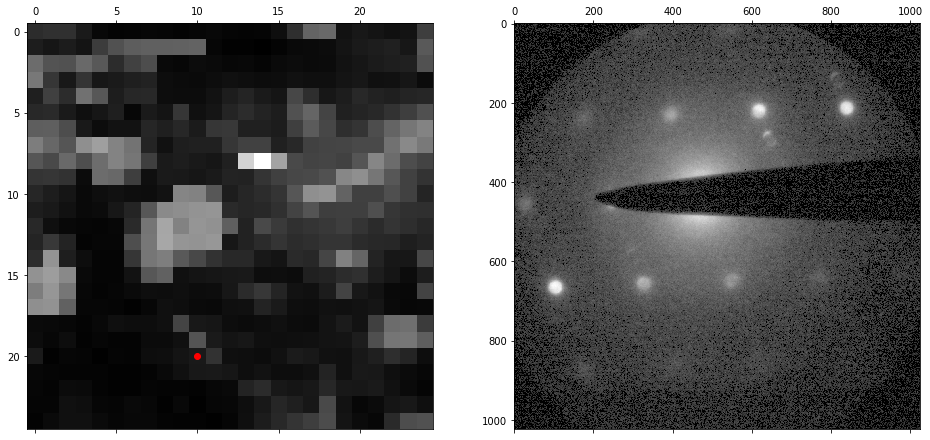

In [13]:
rx,ry = 20,10
power = 0.3

ave_im = np.average(dc.data4D,axis=(2,3))

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.matshow(ave_im)
ax1.scatter(ry,rx,color='r')
ax2.matshow(dc.data4D[rx,ry,:,:]**power)
plt.show()

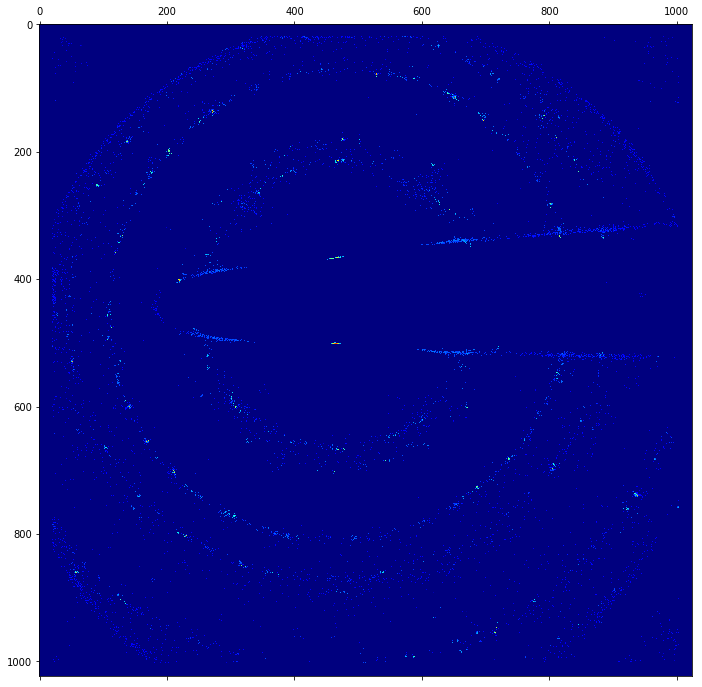

In [24]:
power = 0.2

bvm = py4DSTEM.process.braggdiskdetection.get_bragg_vector_map(braggpeaks,dc.Q_Nx,dc.Q_Ny)

fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(bvm**power,cmap='jet')
plt.show()

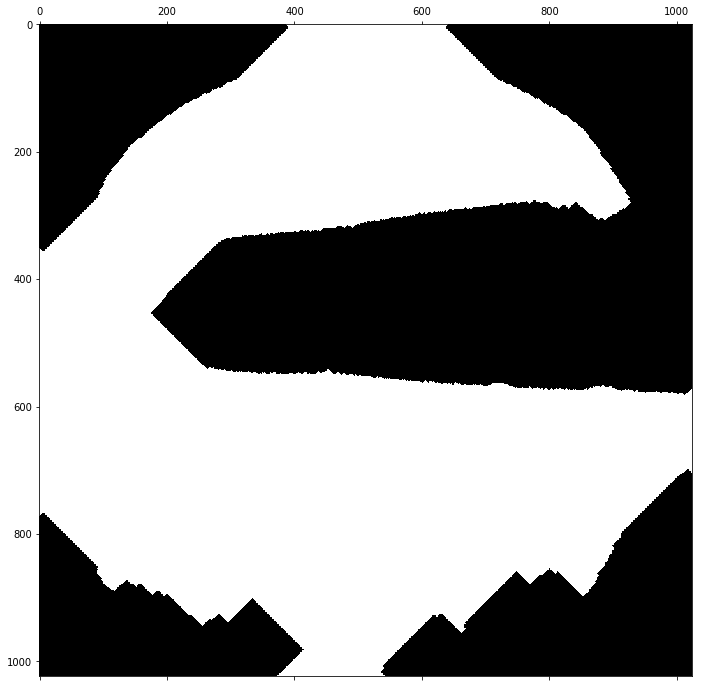

In [76]:
thresh = 0.0001
Rx,Ry = 20,10
n_close = 3
n_open = 3
n_expand = 80
n_DP = 10

mask = np.ones((dc.Q_Nx,dc.Q_Ny),dtype=bool)
for Rx in np.random.randint(0,dc.R_Nx,size=n_DP):
    for Ry in np.random.randint(0,dc.R_Ny,size=n_DP):
        mask_DP = dc.data4D[Rx,Ry,:,:]<np.max(dc.data4D[Rx,Ry,:,:])*thresh
        mask_DP = binary_closing(mask_DP, iterations=n_close)
        mask_DP = binary_opening(mask_DP, iterations=n_open)
        mask = mask*mask_DP        

mask = binary_dilation(mask, iterations=n_expand)
mask = mask==False

fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(mask)
plt.show()

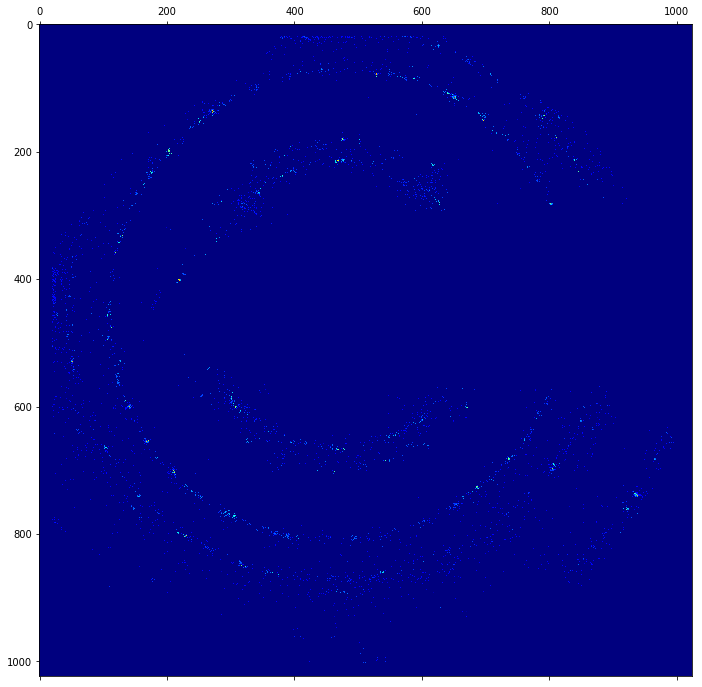

In [77]:
power = 0.2

bvm = py4DSTEM.process.braggdiskdetection.get_bragg_vector_map(braggpeaks,dc.Q_Nx,dc.Q_Ny)

fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(mask*bvm**power,cmap='jet')
plt.show()

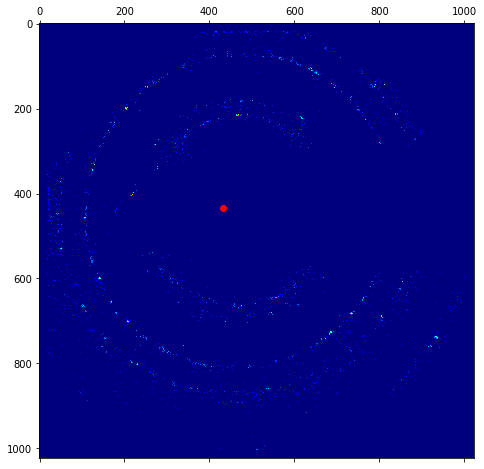

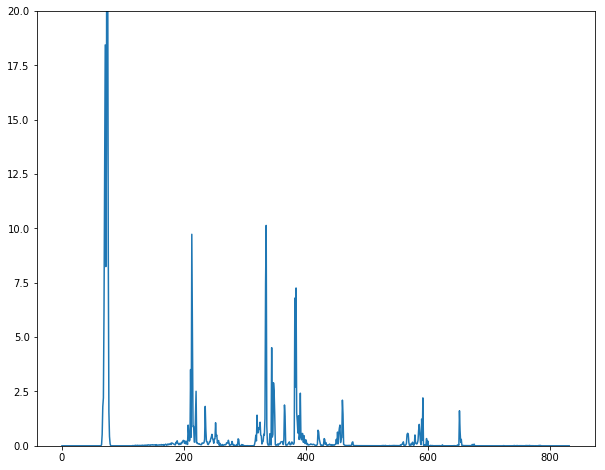

In [85]:
# Get radial profile

ymax=20

x0,y0 = py4DSTEM.process.utils.get_CoM(bvm)
radial_profile = py4DSTEM.process.utils.radial_integral(bvm,x0,y0)[0]

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(mask*bvm**power,cmap='jet')
ax.scatter(y0,x0,color='r')
plt.show()
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(np.arange(len(radial_profile)),radial_profile)
ax.set_ylim(0,ymax)
plt.show()

In [91]:
from matplotlib.patches import Rectangle
Rectangle?

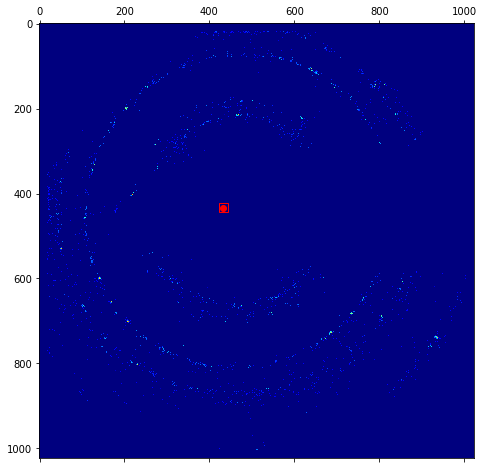

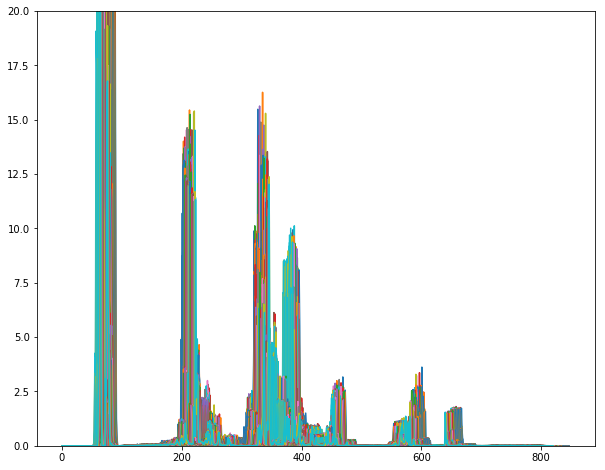

In [101]:
# Get radial profiles with various centers

window_rad = 10
ymax=20

x0,y0 = py4DSTEM.process.utils.get_CoM(bvm)
origin_vals = np.zeros((dc.Q_Nx,dc.Q_Ny),dtype=bool)
origin_vals[int(x0-window_rad):int(x0+window_rad),int(y0-window_rad):int(y0+window_rad)] = True
origin_vals = np.nonzero(origin_vals)

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(mask*bvm**power,cmap='jet')
ax.scatter(y0,x0,color='r')
rect = Rectangle((y0-window_rad,x0-window_rad),2*window_rad,2*window_rad,fill=False,edgecolor='r')
ax.add_patch(rect)
plt.show()



fig,ax = plt.subplots(figsize=(10,8))

for i in range(len(origin_vals[0])):
    x,y = origin_vals[0][i],origin_vals[1][i]
    radial_profile = py4DSTEM.process.utils.radial_integral(bvm,x,y)[0]
    ax.plot(np.arange(len(radial_profile)),radial_profile)

ax.set_ylim(0,ymax)
plt.show()

In [ ]:
# Get radial profile

ymax=20

x0,y0 = py4DSTEM.process.utils.get_CoM(bvm)
radial_profile = py4DSTEM.process.utils.radial_integral(bvm,x0,y0)[0]

fig,ax = plt.subplots(figsize=(10,8))
ax.plot(np.arange(len(radial_profile)),radial_profile)
ax.set_ylim(0,ymax)
plt.show()

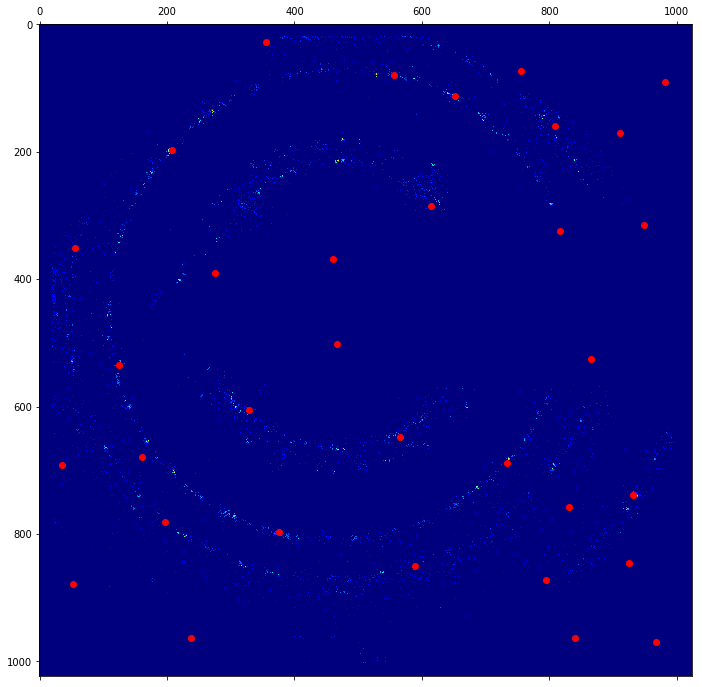

In [79]:
Rx,Ry = 15,15

pointlist = braggpeaks.get_pointlist(Rx,Ry)

fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(mask*bvm**power,cmap='jet')
for i in range(pointlist.length):
    ax.scatter(pointlist.data['qy'][i],pointlist.data['qx'][i],color='r')
plt.show()